# QUANTUM  BLOCKCHAIN

We begin, as usual, importing the libraries and functions we will use.

In [1]:
# Import standard libraries for working with data, arrays, hashes and files
import pandas as pd
import numpy as np
from numpy import pi, sqrt, exp, zeros, where
from hashlib import sha256
from shutil import copy2, copy, rmtree
import os.path
# import warnings
# warnings.simplefilter('ignore')

In [2]:
# Import
from qiskit import Aer, QuantumCircuit, execute, assemble
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info import random_statevector, state_fidelity
from qiskit_textbook.widgets import plot_bloch_vector_spherical

## Node class

Next we define the node class, which encodes each node in the blockchain.

In [3]:
class node:
    '''    
    Class of a node in a blockchain. Creating a blockchain object of n nodes 
    will create n node objects.
    
    Parameters
    ----------
    
    nodes: number of nodes in the blockchain
    node_idx: current node index (integer)
    tran_per_block: transactions per block 
    
    
    Attributes
    ----------
    
    nodes: number of nodes in the blockchain 
    node_idx: number associated with current node
    block_path: path of the current block
    tran_path: path of the transactions csv
    fid_path: path of the fidelity csv
    tran_per_block: fixed number of transactions per block
    tran_count: count of the number of transactions made
    winners: winners of the last block
        
        
    Methods
    -------
    
    transaction: create a transaction between nodes
    create_block: creates a new block with the stored transactions and previous block fidelities.
    update_winners: update winners after block is solved
    write_fidelity: rewrites current fidelity in a file
    sha256_block: pass the block through sha256 hash function
    state_parameters: create block quantum state parameters from hash
    
    '''
    
    def __init__(self, nodes, node_idx, tran_per_block):
        '''Initialize block class. Initializes block number to 1, sets first block's path,
        number of nodes in the blockchain and transaction count.
        
        '''
        self.nodes = list(range(nodes))
        self.node_idx = node_idx
        self.block_path = os.path.join('Node' + str(node_idx), 'Blocks', 'block1.csv')
        self.tran_path = os.path.join('Node' + str(node_idx), 'transactions.csv')
        self.fid_path = os.path.join('Node' + str(node_idx), 'fidelity.csv')
        self.tran_per_block = tran_per_block
        self.block_count = 1
        self.tran_count = tran_per_block
        self.winners = [0,1]
        
 
    def transaction(self, node_1, sends, node_2):
        '''Add a transaction from node_1 to node_2 sending an amount of coins.
        
        Parameters
        ----------
        node_1: integer corresponding to the sending node's number
        sends: coins node_1 sends to node_2
        node_2: integer corresponding to the receiving node's number
        
        '''
        
        if node_1 == node_2:
            raise Exception('Error, node cannot send coins to itself.')
        
        prev_block = pd.read_csv(self.block_path)
        prev_block.set_index('Node', inplace=True)
        
        if prev_block.loc[node_1,'Wallet'] < sends:
            raise Exception('Error, not enough funds in wallet.')
        
        # Authorised transaction
        self.tran_count +=1
        
        list_tran = np.zeros(len(self.nodes))
        list_tran[node_1]= - float(sends)
        list_tran[node_2] = float(sends)
        
        # Save transactions to the transaction csv
        
        df_tran = pd.read_csv(self.tran_path)
        df_tran.set_index('Node', inplace=True)
        
        tran_header = 'Transaction ' + str(self.tran_count)
        df_tran[tran_header] = list_tran
        df_tran.to_csv(self.tran_path)
        
    
    def create_block(self, random_numbers):
        '''Write block information in a text file: block number, previous state and two transactions. 
        
        Parameters
        ----------
        random_numbers: strings list
        
        '''
        # Read necessary csv files: transactions.csv, fidelity.csv, block.csv
        
        prev_block = pd.read_csv(self.block_path)
        prev_block.set_index('Node', inplace=True)
        
        prev_fid = pd.read_csv(self.fid_path)
        prev_fid.set_index('Node', inplace=True)
        
        new_block = pd.DataFrame({'Node': self.nodes,
                                 'Old Wallet': prev_block['Wallet'].tolist(),
                                 'Random number': random_numbers},
                                 dtype=object)
        new_block.set_index('Node', inplace=True)
        
        # Add transactions to the block
        df_tran = pd.read_csv(self.tran_path)
        
        coins_update = np.zeros(len(self.nodes))
        
        for i in range(self.tran_count-self.tran_per_block+1,self.tran_count+1):
            tran_header = 'Transaction ' + str(i)
            tran_i= df_tran[tran_header].tolist()
            new_block[tran_header] = tran_i
            coins_update += np.asarray(tran_i)
        
        
        # Nodes get payment for solving previous block
        # fid = new_block['prev_fidelity'].tolist()
        # max_fidelity = fid.index(max(fid))
        
        payment = 0.2*np.ones(len(self.nodes)) 
        payment[self.winners[0]]=0.6
        payment[self.winners[1]]=0.6
        
        new_block['Payment'] = list(payment)     
        old_wallet = np.asarray(new_block['Old Wallet'].tolist())
        new_block['Wallet'] = list(np.round(old_wallet + coins_update + payment,4))
        
        # Add previous block fidelities to the block
        
        new_block = pd.concat([new_block, prev_fid], axis=1)

        # Update path and save block
        self.block_path = os.path.join('Node'+str(self.node_idx),'Blocks','block'+str(self.block_count+1)+'.csv')
        new_block.to_csv(self.block_path)
        self.block_count += 1

    def update_winners(self, winners):
        '''Update winners attribute in node.
        
        Parameters
        ----------
        winners: list of 2 winners
        
        '''
        self.winners = winners
        
        
    def write_fidelity(self, fid_table):
        '''Write fidelity table into fidelity.csv '''
        
        fid = pd.DataFrame({'Node': self.nodes}, dtype=object)
        for i in self.nodes:
            fid['Fidelity node ' + str(i)] = fid_table[:,i]
        fid.set_index('Node', inplace=True)
        fid.to_csv(self.fid_path)
        
        
    def sha256_block(self, block_path):
        '''Create a hash from the block csv file. '''
        
        with open(block_path, mode='rb') as block_file:
            content = block_file.read()
            sha256_hash = sha256(content)
    
        return sha256_hash.hexdigest()
    
    
    def state_parameters(self, block_path):
        '''Create angles of the qubit from the block's hash. '''
        
        sha = self.sha256_block(block_path)
        θ = int(sha[0:32],16) % (2*pi)
        ϕ = int(sha[32:],16) % (pi)
        
        return list([θ, ϕ])   
            

## Blockchain class

Next we define what will be our main class: the blockchain. It contains all the functions that we need to set up a full working blockchain from scratch.

In [4]:
class blockchain:
    ''' Class of a full blockchain. When created it sets up the initial folders and creates the node objects.

    Parameters
    ----------
    
    node_number: number of nodes in the blockchain
    tran_per_block: number of transactions per block
    rand_length: length of the random numbers the blockchain generates

    Attributes
    ----------
    
    node_number: number of nodes in the blockchain (integer)
    nodes: list of node indices (list of integers)
    tran_per_block: transactions per block
    node_list: a list of node objects, one for each node in the blockchain
    rand_length: an integer with the length of the random numbers.
    
    '''
    
    def __init__(self, node_number, tran_per_block, rand_length):
        '''Initialize files for every node and create node objects. '''
        
        self.node_number = node_number
        self.nodes = list(range(node_number))
        self.tran_per_block = tran_per_block
        self.rand_length = rand_length

        # Create initialize transactions and first block csv
        
        self.initialize_files()
        
        # Create one node object for each node 
        
        self.node_list=[]
        for i in range(self.node_number):
            self.node_list.append(node(self.node_number, i, self.tran_per_block))
            
            # Copy inital folders and files for each node 
            
            node_folder = os.path.join('Node' + str(i))
            block_folder = os.path.join(node_folder, 'Blocks')
            
            if os.path.exists(node_folder):
                rmtree(node_folder)
            
            os.makedirs(node_folder, exist_ok = True)
            os.makedirs(block_folder, exist_ok = True)

            copy2(os.path.join('Initialize','transactions.csv'), node_folder)
            copy2(os.path.join('Initialize','fidelity.csv'), node_folder)
            copy2(os.path.join('Initialize','block1.csv'), block_folder)
           
    
    
    def initialize_files(self):
        '''Initialize transaction file with 20 coins to every node in the first
        transaction and zero in the rest transactions of the first block.
        Iniitialize fidelities to random numbers between 0 and 1. '''

        # Create data as pandas dataframe
        
        initial_tran = pd.DataFrame({'Node': list(range(self.node_number)),
                                 'Transaction 1': list(np.ones(self.node_number)*20)}, dtype=object)
        initial_tran.set_index('Node',inplace=True)
        
        initial_fid = pd.DataFrame({'Node': list(range(self.node_number))}, dtype=object)
        initial_fid.set_index('Node',inplace=True)
        
        for i in range(2,self.tran_per_block+1):
            initial_tran['Transaction ' + str(i)] = list(np.zeros(self.node_number))
            
        for i in self.nodes:
            initial_fid['prev_fidelity ' + str(i)] = list(np.random.random_sample(self.node_number,))
        
        # Create Initialize folder and copy the csv's
        
        os.makedirs('Initialize', exist_ok = True)
        initial_tran.to_csv(os.path.join('Initialize', 'transactions.csv'))
        initial_fid.to_csv(os.path.join('Initialize', 'fidelity.csv'))
        
        # Initialize first block file for every node with 0 coins in old wallet
        # and 20 coins in wallet after the first transaction

        initial_block = pd.DataFrame({'Node': list(range(self.node_number)),
                                      'Old Wallet': list(np.zeros(self.node_number)),
                                      'Wallet': list(np.ones(self.node_number)*20),
                                      'Payment': list(np.zeros(self.node_number)),
                                      'Random number': ['00000' for i in range(self.node_number)]},
                                     dtype=object)               
        
        initial_block = pd.concat([initial_tran, initial_block, initial_fid], axis=1)
        initial_block.to_csv(os.path.join('Initialize','block1.csv'))
        
        
        
    def random_numbers(self):
        '''Create one random number sequence for each node. One can obtain one sequence from
        the rest, which can be used to verify that the sequences were obtained by the prescribed
        precedure in this function.
        
        References
        ----------
        [1] Janusz E., Jacak, Witold A. Jacak, Wojciech A. Donderowicz & Lucjan Jacak (2020), 
        "Quantum random number generators with entanglement for public randomness testing". Nature.
        
        '''
    
        def random_digits():
            '''Create the individual numbers of the sequences of random numbers using a
            quantum circuit with entangled states.
            '''
        
            circ = QuantumCircuit(self.node_number,self.node_number)
    
            for i in range(self.node_number-1):
                circ.h(i)
                circ.cx(i,self.node_number-1)
                
            for i in range(self.node_number):
                circ.measure(i,i)   
            
            # circ.draw('mpl')
            backend = Aer.get_backend('qasm_simulator')
            job = execute(circ, backend,shots=1)
            
            return job.result().get_counts()
        
        # Initialize and create the list of strings of random sequences
        rand_string = ['']*self.node_number
    
        for j in range(self.rand_length):
            # Measure the quantum circuit and get the resulting bits
            measure = list(random_digits().keys())[0]
            
            # Join each the characters to create strings
            for i in range(self.node_number):
                rand_string[i] += measure[i]

        return rand_string
    
        
        
    def send_states(self,angles):
        '''Each nodes sends its block state (obtained through hashing) to the rest of nodes by a
        Quantum Teleportation protocol, which ensures the blockchain is made up of Quantum Computers
        and Quantum Information channels. The function returns the qubit state after teleportation
        (which should be the same if everything went OK).'''
    
        def create_bell_pair(circ, q1, q2):
            '''Creates a bell pair in quantum circuit using qubits a and b'''
            circ.h(q1)
            circ.cx(q1,q2)
    
        def node1_gates(circ, psi, q1):
            '''Create sending node gates'''
            circ.cx(psi, q1)
            circ.h(psi)

        def measure_and_send(circ, q1, q2):
            '''Measures qubits q1 and q2 and 'sends' the results to node2'''
            circ.barrier()
            circ.measure(q1,0)
            circ.measure(q2,1)

        def node2_gates(circ, qubit, crz, crx):
            '''Create receiving node gates'''
            circ.x(qubit).c_if(crx, 1) 
            circ.z(qubit).c_if(crz, 1) 
    
        # Generate the qubit we want to send with the parameters θ and ϕ
        
        state_circ = QuantumCircuit(1)
        state_circ.u(angles[0], angles[1],0,0)
        
        # Measure the circuit after we rotated |0> vector
        
        backend = Aer.get_backend('qasm_simulator')
        state_circ.save_statevector()
        qobj = assemble(state_circ)     # Create a Qobj from the circuit for the simulator to run
        result = backend.run(qobj).result() 
        psi = result.get_statevector()
        
        # Once we have our state ready to send we begin the teleportation protocol
        
        init_gate = Initialize(psi)
        init_gate.label = "init"

        # Protocol uses 3 qubits and 2 classical bits in 2 different registers
        qr = QuantumRegister(3, name="q")
        crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
        teleport_circ = QuantumCircuit(qr, crz, crx)

        # Step 1
        teleport_circ.append(init_gate, [0])
        create_bell_pair(teleport_circ, 1, 2)

        # Step 2
        node1_gates(teleport_circ, 0, 1) 

        # Step 3
        measure_and_send(teleport_circ, 0, 1)

        # Step 4
        node2_gates(teleport_circ, 2, crz, crx)
        
        # Finally we determine the received state
        teleport_circ.save_statevector()   # Tell simulator to save statevector
        qobj = assemble(teleport_circ)     # Create a Qobj from the circuit for the simulator to run
        result = backend.run(qobj).result() 
        out_state = result.get_statevector()
        
        # We obtain final state in two parts
        
        part1 = np.asarray(out_state[0:4])
        part2 = np.asarray(out_state[4:8])
    
        return [max(part1.min(), part1.max(),key=abs), max(part2.min(), part2.max(), key=abs)]
    
    
 
    def fidelity_table(self, states):
        '''Given the states of each node's last block, obtain the fidelities.
        Each node compares its vector to other nodes vector. One's own fidelity is set to 0 by default.
        Otherwise, it would always be 1.
        
        Input:
        - states: array of each node state
        Output:
        - fid_table: table of fidelities as a numpy array
        '''
        
        fid_table = np.zeros((self.node_number,self.node_number))
        for i in range(self.node_number):
            fid_table[i,i]=0
            for j in range(i):
                fid = state_fidelity(states[i], states[j], validate=True)
                fid_table[i,j] = fid
                fid_table[j,i] = fid
        
        # We write the fidelity table that each node finds in its fidelity csv
        
        for node in self.node_list:
            node.write_fidelity(fid_table)
        
        return np.asarray(fid_table)


    def get_winners(self, fid_table):
        '''Check fidelities table and select the winners.'''
        
        fid_table = np.asarray(fid_table)
        max_idx = list(np.unravel_index(np.argmax(fid_table, axis=None), fid_table.shape))
        
        return max_idx
        
        
    def update_blocks(self, winners): 
        '''Tell nodes the winners and overwrite nodes last block with first winner's block.
        Both winners will receive a monetary prize.'''
        
        winner_path = os.path.join('Node' + str(winners[0]), 'Blocks', 'block' + str(self.node_list[0].block_count) + '.csv')
        
        for i, node in enumerate(self.node_list):
            node.update_winners(winners)
            if i == winners[0]:
                continue        
            copy(winner_path, os.path.join('Node' + str(i), 'Blocks'))
    
    

    def solve_block(self):
        '''Once a block is solved, begin the process of solving the block by each node and determining the winners.'''
        
        # get the random numbers generated by each node
        rand_num = []
        for i in self.nodes:
            rand_num.append(self.random_numbers())
        rand_num = np.array(rand_num, dtype = object)
                
        # Each node sends one random number to another node (including itself)
        # That is, each node receives a random number from each node (including itself)
        # Then each node creates its block
        
        for i, node in enumerate(self.node_list):
            node.create_block(list(rand_num[i,:]))
        
        # Each node sends its block's quantum hashed state to the rest of the nodes
        
        states = []
        for node in self.node_list:
            states.append(self.send_states(node.state_parameters(node.block_path)))
        
        # Each node calculates fidelities and determine the winners
        
        fid_table = self.fidelity_table(states)
        winners = self.get_winners(fid_table)
        
        # Tell each block who whon and update winners
        
        self.update_blocks(winners) # update all nodes blocks with one of the winners block
        
    
    
    def add_transactions(self, node_send, send, node_receive):
        '''Add transactions to the blockchain.
        
        Input:
        - node_send: list of nodes sending coins
        - send: list of coins sent (one corresponding to each node)
        - node_receive: list of nodes that receive the coins
        '''
        
        for i in range(len(send)):
            
            for node in self.node_list: 
                node.transaction(node_send[i], send[i], node_receive[i])
            
            # All the nodes receive the same transactions. If a block is to be filled then 
            # block resolving process begins.
            
            if (self.node_list[self.node_number-1].tran_count % self.tran_per_block) == 0:
                self.solve_block()
                
        

# Creating a first blockchain

With just one command, defining one python object, we can setup our first blockchain... indeed, a Quantum Blockchain! When the object initializes, nodes folders containing transactions and blocks are created from an initialize folder (also created from scratch). When creating a blockchain we can pass in some parameters, like number of nodes, number of transactions per block and the length of some random sequences used in the algorithm (created using entangled quantum circuits). 

In [5]:
# Quantum Blockchain with 6 nodes, 3 transactions per block and length 10 of random sequences
Quantum_Blockchain = blockchain(6,3,10)

Adding transactions to the blockchain is easy. You can input them with arrays in the add_transactions method in the blockchain class. 

In [7]:
# Let's add our first transactions to the blockchain

sending_node = [1,2,2,3,5,0,2]
coins_sent = [2,3,1,3,3,5,1]
receiving_node = [0,1,3,4,3,1,1]

Quantum_Blockchain.add_transactions(sending_node, coins_sent, receiving_node)

We can visualize the transactions file, for example, node 3 transaction file. Note that the sending node appears with negative coins and the receiving node with positive coins.

In [8]:
transaction = pd.read_csv(os.path.join('Node3','transactions.csv'))
transaction.head()

,Node,Transaction 1,Transaction 2,Transaction 3,Transaction 4,Transaction 5,Transaction 6,Transaction 7,Transaction 8,Transaction 9,Transaction 10,Transaction 11,Transaction 12,Transaction 13,Transaction 14,Transaction 15,Transaction 16,Transaction 17
0,0,20.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,-5.0,0.0,2.0,0.0,0.0,0.0,0.0,-5.0,0.0
1,1,20.0,0.0,0.0,-2.0,3.0,0.0,0.0,0.0,5.0,1.0,-2.0,3.0,0.0,0.0,0.0,5.0,1.0
2,2,20.0,0.0,0.0,0.0,-3.0,-1.0,0.0,0.0,0.0,-1.0,0.0,-3.0,-1.0,0.0,0.0,0.0,-1.0
3,3,20.0,0.0,0.0,0.0,0.0,1.0,-3.0,3.0,0.0,0.0,0.0,0.0,1.0,-3.0,3.0,0.0,0.0
4,4,20.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0


If a node tries to send coins without enough funds in the wallet then an **_Excecption Error_** is risen. The same thing happens if a node tries to send coins to itself.

In [9]:
Quantum_Blockchain.add_transactions([1], [1000], [2])

Exception: Error, not enough funds in wallet.

We can also visualize the data in the blockchain. For example, lets see block number 2 of node 4. We see that each block stores the old wallet data, a random number given by each node, the transactions, the payment for solving the previous block, the new wallet and the fidelity table.

In [10]:
# node4 = Quantum_Blockchain.node_list[4]
block = pd.read_csv(os.path.join('Node4', 'Blocks', 'block2.csv'))
block.head()

,Node,Old Wallet,Random number,Transaction 4,Transaction 5,Transaction 6,Payment,Wallet,prev_fidelity 0,prev_fidelity 1,prev_fidelity 2,prev_fidelity 3,prev_fidelity 4,prev_fidelity 5
0,0,20.0,100111011,2.0,0.0,0.0,0.6,22.6,0.086564,0.832767,0.603927,0.925505,0.079993,0.374225
1,1,20.0,110011010,-2.0,3.0,0.0,0.6,21.6,0.615390,0.721543,0.526879,0.811956,0.892432,0.725915
2,2,20.0,101111011,0.0,-3.0,-1.0,0.2,16.2,0.184886,0.930564,0.501477,0.978825,0.304090,0.502271
3,3,20.0,110110011,0.0,0.0,1.0,0.2,21.2,0.257385,0.635429,0.812465,0.159712,0.069685,0.810943
4,4,20.0,1000010010,0.0,0.0,0.0,0.2,20.2,0.524989,0.282344,0.207671,0.236905,0.473196,0.435758


When transactions feel a block, nodes create a hash for each block, which then is converted to a Quantum State that is teleported (using Quantum teleportation protocol) to the rest of the nodes. The nodes compare the fidelities of their block states and the states of the rest of the nodes. Let's visualize the Qubit obtained by hashing node4 second block.

In [11]:
node4 = Quantum_Blockchain.node_list[4]
block_path = os.path.join('Node4','Blocks','block2.csv')

hash_angles = node4.state_parameters(block_path)
print('Hashed block state: ', hash_angles)

Hashed block state:  [5.486042967835502, 0.8794258561728192]


Because this is a Hash, you should verify that everytime it's called, it retrieves the same angles (for the same document). Let's now represent it in Bloch Sphere:

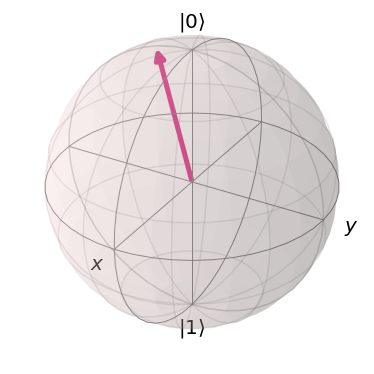

In [12]:
# We add last coordinate (radial) as 1
qubit_vector = hash_angles + [1]
plot_bloch_vector_spherical(qubit_vector)

As we said, this state is then sent throgh a Quantum Channel using a Quantum Teleportation Protocol, which uses entangled states to share a Qubit. This is done with the method _send_states_.

In [14]:
Quantum_Blockchain.send_states(hash_angles)

[(-0.9216164663526257+0j), (0.24745127320545293+0.2989832041046779j)]

Which is the same as the input vector. This can be verify builing the circuit that rotates $|0\rangle$ by angles $\theta$ and $\phi$ in hash_angles

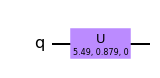

In [15]:
# Circuit to rotate |0>
state_circ = QuantumCircuit(1)
state_circ.u(hash_angles[0], hash_angles[1],0,0)
        
state_circ.draw('mpl')

In [16]:
# Get final state after passing |0> throught the circuit

backend = Aer.get_backend('qasm_simulator')
state_circ.save_statevector()
qobj = assemble(state_circ)     # Create a Qobj from the circuit for the simulator to run

result = backend.run(qobj).result() 
result.get_statevector()

array([-0.92161647-0.j       ,  0.24745127+0.2989832j])

Once the states are sent, each node calculates the fidelities. They should all agree in the fidelities table! We can visualize the last fidelity table obtained by node 0.

In [17]:
fidelity = pd.read_csv(os.path.join('Node0','fidelity.csv'))
fidelity.head()

,Node,Fidelity node 0,Fidelity node 1,Fidelity node 2,Fidelity node 3,Fidelity node 4,Fidelity node 5
0,0,0.000000,0.645119,0.640655,0.772103,0.842968,0.165244
1,1,0.645119,0.000000,0.414973,0.352161,0.327871,0.745986
2,2,0.640655,0.414973,0.000000,0.958288,0.881148,0.222238
3,3,0.772103,0.352161,0.958288,0.000000,0.978727,0.080883
4,4,0.842968,0.327871,0.881148,0.978727,0.000000,0.022757


Fidelities are obtained projecting the sent qubit to the node's own qubit state. Of course, in reality this is done with many copies of the same vectors and calculating the probabilities to measure one in the others basis. It is then important that we know how to build this states in a unique way. This is done with the _sha256_block_ and _state_parameters_ method of the node class.

## Play with the blockchain!

Once we have seen the basics of this blockchain, we invite you to investigate the functions and discover by yourself how it works!

In [ ]:
# Your code